<a href="https://colab.research.google.com/github/prarthananbhat/tsai/blob/master/Step2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
!pip install torchsummary
from torchsummary import summary
import matplotlib.pyplot as plt

In [0]:
# Create the data reader and transformer
train_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))])
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.1307,), (0.3081,))])


In [3]:
train = datasets.MNIST('./data',
                       train=True,
                       transform = train_transform,
                       download = True)
test = datasets.MNIST('./data',
                       train=False,
                       transform = test_transform,
                       download = True)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [4]:
# Set seed for all the environments
SEED = 1
torch.manual_seed(SEED)

CUDA = torch.cuda.is_available()
print("CUDA is available:",CUDA)
# If CUDA is available the set SEED for it
if CUDA:
    torch.cuda.manual_seed(SEED)


CUDA is available: True


In [0]:
# DATA LOADER
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if CUDA else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train,**dataloader_args)
# test dataloader
test_loader = torch.utils.data.DataLoader(test,**dataloader_args)

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


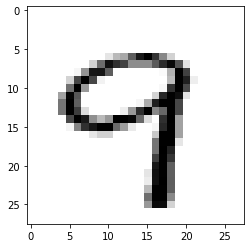

In [6]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

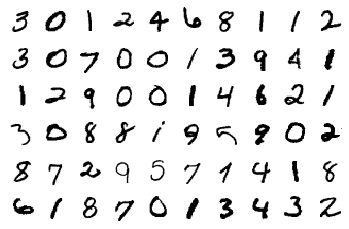

In [7]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # FIRST LAYER
        self.conv_block_1 = nn.Conv2d(in_channels = 1,
                                      out_channels = 4,
                                      kernel_size=3, 
                                      stride = 1,
                                      padding=0,
                                      bias=True
                                      ) #output size = 26 Receptive field = 3
        
        # CONVOLUTION BLOCK
        self.conv_block_2 = nn.Sequential(nn.Conv2d(in_channels=4,
                                                    out_channels=8,
                                                    kernel_size=3,
                                                    stride=1,
                                                    padding=0,
                                                    bias = True), #Output Size = 24, Receptive Field = 5
                                          nn.ReLU()
        ) 
        self.conv_block_3 = nn.Sequential(nn.Conv2d(in_channels=8,
                                                    out_channels=16,
                                                    kernel_size=3,
                                                    stride=1,
                                                    padding=0,
                                                    bias = True),  #Output size = 22 Receptive field = 7
                                          nn.ReLU()
        )
        
        # TRANSITION BLOCK
        self.pool_1 = nn.MaxPool2d(kernel_size=2,stride=2,padding=0) #  #Output size = 11 Receptive field = 8
        self.conv_block_4 = nn.Sequential(nn.Conv2d(in_channels=16,
                                                    out_channels=4,
                                                    kernel_size=1,
                                                    stride=1,
                                                    padding=0,
                                                    bias = True), #Output size = 11 Receptive field = 12
                                          nn.ReLU()
        )

        # CONVOLUTION BLOCK
        self.conv_block_5 = nn.Sequential(nn.Conv2d(in_channels=4,
                                                    out_channels=8,
                                                    kernel_size=3,
                                                    stride=1,
                                                    padding=0,
                                                    bias = True), #Output size = 9 Receptive field = 16
                                          nn.ReLU()
        )
        self.conv_block_6 = nn.Sequential(nn.Conv2d(in_channels=8,
                                                    out_channels=16,
                                                    kernel_size=3,
                                                    stride=1,
                                                    padding=0,
                                                    bias = True), #Output size = 7 Receptive field = 20
                                          nn.ReLU()
        )

        # OUTPUT LAYER
        self.conv_block_7 = nn.Sequential(nn.Conv2d(in_channels=16,
                                                    out_channels=10,
                                                    kernel_size=1,
                                                    stride=1,
                                                    padding=0,
                                                    bias = True), #Output size = 7 Receptive field = 20
                                          nn.ReLU()
        )
        self.conv_block_8 = nn.Sequential(nn.Conv2d(in_channels=10,
                                                    out_channels=10,
                                                    kernel_size=7,
                                                    stride=1,
                                                    padding=0,
                                                    bias = True) #Output size = 1 Receptive field = 24
        ) 

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        x = self.pool_1(x)
        x = self.conv_block_4(x)
        x = self.conv_block_5(x)
        x = self.conv_block_6(x)
        x = self.conv_block_7(x)
        x = self.conv_block_8(x)
        x = x.view(-1, 10)
        final_x = F.log_softmax(x, dim=-1)
        return final_x

In [9]:
device = torch.device("cuda" if CUDA else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 26, 26]              40
            Conv2d-2            [-1, 8, 24, 24]             296
              ReLU-3            [-1, 8, 24, 24]               0
            Conv2d-4           [-1, 16, 22, 22]           1,168
              ReLU-5           [-1, 16, 22, 22]               0
         MaxPool2d-6           [-1, 16, 11, 11]               0
            Conv2d-7            [-1, 4, 11, 11]              68
              ReLU-8            [-1, 4, 11, 11]               0
            Conv2d-9              [-1, 8, 9, 9]             296
             ReLU-10              [-1, 8, 9, 9]               0
           Conv2d-11             [-1, 16, 7, 7]           1,168
             ReLU-12             [-1, 16, 7, 7]               0
           Conv2d-13             [-1, 10, 7, 7]             170
             ReLU-14             [

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [11]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.37285253405570984 Batch_id=468 Accuracy=33.45: 100%|██████████| 469/469 [00:10<00:00, 49.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3083, Accuracy: 9121/10000 (91.21%)

EPOCH: 1


Loss=0.15158112347126007 Batch_id=468 Accuracy=94.49: 100%|██████████| 469/469 [00:10<00:00, 43.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1108, Accuracy: 9665/10000 (96.65%)

EPOCH: 2


Loss=0.2759246528148651 Batch_id=468 Accuracy=96.90: 100%|██████████| 469/469 [00:11<00:00, 42.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0938, Accuracy: 9709/10000 (97.09%)

EPOCH: 3


Loss=0.08842861652374268 Batch_id=468 Accuracy=97.77: 100%|██████████| 469/469 [00:11<00:00, 40.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0770, Accuracy: 9775/10000 (97.75%)

EPOCH: 4


Loss=0.061460498720407486 Batch_id=468 Accuracy=97.97: 100%|██████████| 469/469 [00:11<00:00, 41.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0641, Accuracy: 9793/10000 (97.93%)

EPOCH: 5


Loss=0.006465961690992117 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:11<00:00, 41.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0616, Accuracy: 9816/10000 (98.16%)

EPOCH: 6


Loss=0.07245678454637527 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:11<00:00, 42.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0564, Accuracy: 9821/10000 (98.21%)

EPOCH: 7


Loss=0.0255791787058115 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:11<00:00, 41.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0537, Accuracy: 9828/10000 (98.28%)

EPOCH: 8


Loss=0.0956367775797844 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:11<00:00, 40.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0576, Accuracy: 9825/10000 (98.25%)

EPOCH: 9


Loss=0.02023719809949398 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:10<00:00, 42.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0581, Accuracy: 9830/10000 (98.30%)

EPOCH: 10


Loss=0.035731568932533264 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:11<00:00, 51.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0510, Accuracy: 9834/10000 (98.34%)

EPOCH: 11


Loss=0.027428587898612022 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:11<00:00, 42.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0565, Accuracy: 9837/10000 (98.37%)

EPOCH: 12


Loss=0.01884286105632782 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:11<00:00, 41.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0571, Accuracy: 9824/10000 (98.24%)

EPOCH: 13


Loss=0.01760629378259182 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:11<00:00, 40.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0522, Accuracy: 9846/10000 (98.46%)

EPOCH: 14


Loss=0.013554220087826252 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:11<00:00, 42.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0550, Accuracy: 9840/10000 (98.40%)

EPOCH: 15


Loss=0.023055195808410645 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:11<00:00, 40.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0508, Accuracy: 9849/10000 (98.49%)

EPOCH: 16


Loss=0.009210835210978985 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:11<00:00, 42.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0526, Accuracy: 9838/10000 (98.38%)

EPOCH: 17


Loss=0.0555388443171978 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:11<00:00, 42.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0568, Accuracy: 9831/10000 (98.31%)

EPOCH: 18


Loss=0.009419460780918598 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:11<00:00, 41.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0671, Accuracy: 9824/10000 (98.24%)

EPOCH: 19


Loss=0.027669528499245644 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:11<00:00, 42.15it/s]



Test set: Average loss: 0.0511, Accuracy: 9849/10000 (98.49%)



Text(0.5, 1.0, 'Test Accuracy')

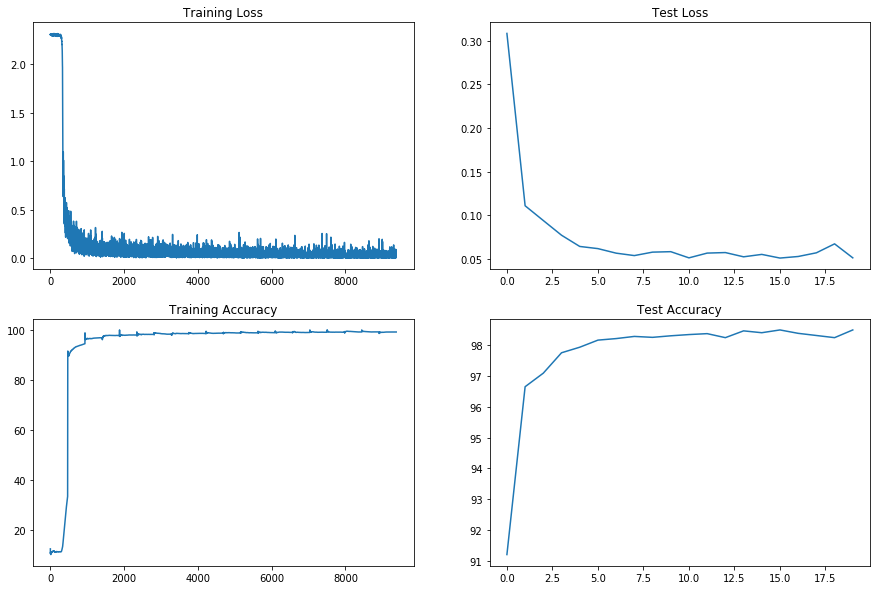

In [12]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [0]:
import numpy as np
train_acc_np = np.array(train_acc)
train_acc_np_reshaped = train_acc_np.reshape(20,469)

In [30]:
train_acc_np_reshaped.mean(axis=1)

array([15.0563089 , 92.85205131, 96.68286541, 97.72362811, 97.93885053,
       98.22384612, 98.49518521, 98.55142025, 98.62337509, 98.72021956,
       98.84396382, 98.92512562, 99.00395853, 99.07473787, 99.04747073,
       99.14267811, 99.15174257, 99.29682922, 99.28815315, 99.12704327])